In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import geopandas as gpd
import rasterio
from rasterio.plot import show, show_hist
from rasterio.warp import calculate_default_transform, reproject, Resampling
from skimage.feature import match_template
import numpy as np
from PIL import Image
import os

In [2]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [3]:
# from google.colab import files
# uploaded = files.upload()

# Shape file 

In [4]:
# open labeled trees shapefile
tree_data = gpd.read_file('trees.shp')
print('CRS of point data: ' + str(tree_data.crs))

CRS of point data: epsg:4326


# Raster file

In [5]:
# open NYC Central Park raster file
park_raster = rasterio.open('NYC_CentralPark.tif')
print('CRS of raster data: ' + str(park_raster.crs))
print('Number of raster bands: ' + str(park_raster.count))
print('Interpretation of raster bands: ' + str(park_raster.colorinterp))

CRS of raster data: EPSG:26918
Number of raster bands: 4
Interpretation of raster bands: (<ColorInterp.red: 3>, <ColorInterp.green: 4>, <ColorInterp.blue: 5>, <ColorInterp.undefined: 0>)


# Reprojection

In [6]:
dst_crs = 'epsg:4326'
with rasterio.open('NYC_CentralPark.tif') as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open('NYC_CentralPark_84.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

In [7]:
# open NYC Central Park 84 raster file
park_raster = rasterio.open('NYC_CentralPark_84.tif')
print('CRS of raster data: ' + str(park_raster.crs))
print('Number of raster bands: ' + str(park_raster.count))
print('Interpretation of raster bands: ' + str(park_raster.colorinterp))

CRS of raster data: EPSG:4326
Number of raster bands: 4
Interpretation of raster bands: (<ColorInterp.red: 3>, <ColorInterp.green: 4>, <ColorInterp.blue: 5>, <ColorInterp.alpha: 6>)


Now, the CRS of shape file is align with the CRS of raster file.

# Plot all trees

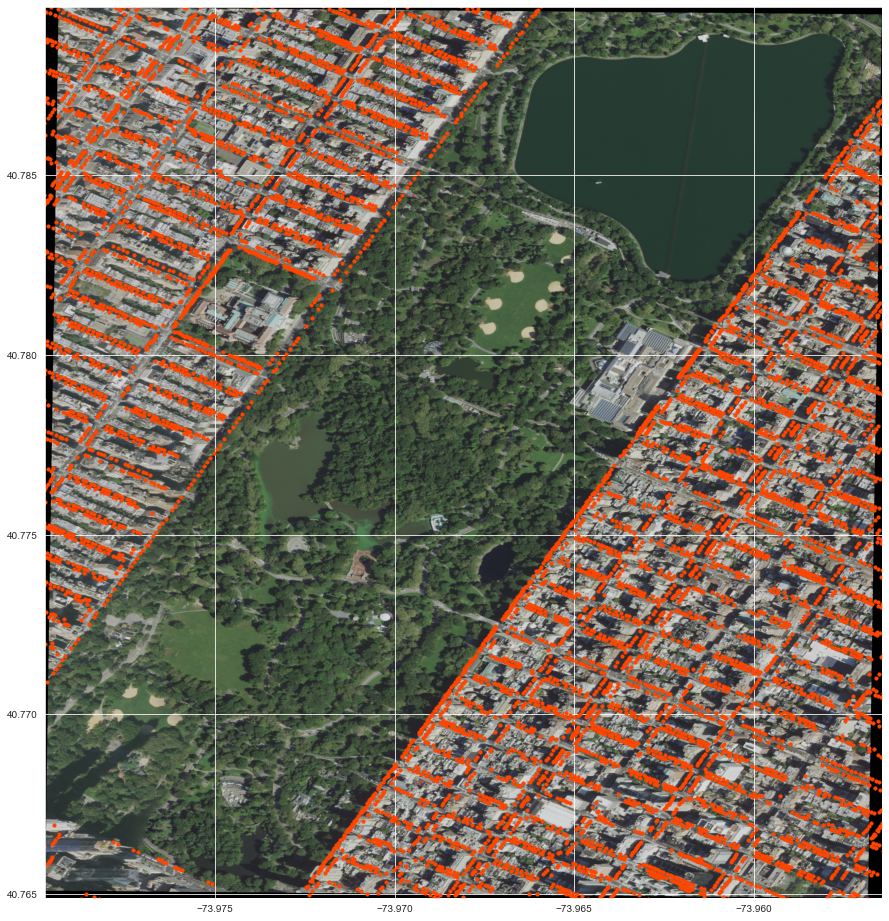

In [8]:
# show point and raster on a matplotlib plot
fig, ax = plt.subplots(figsize=(15,20))
tree_data.plot(ax=ax, color='orangered', markersize=10)
show(park_raster, ax=ax);

# Missing values in shape file

In [9]:
columns = tree_data.columns.values.tolist()
columns

['tree_id',
 'block_id',
 'created_at',
 'tree_dbh',
 'stump_diam',
 'curb_loc',
 'status',
 'health',
 'spc_latin',
 'spc_common',
 'steward',
 'guards',
 'sidewalk',
 'user_type',
 'problems',
 'root_stone',
 'root_grate',
 'root_other',
 'trunk_wire',
 'trnk_light',
 'trnk_other',
 'brch_light',
 'brch_shoe',
 'brch_other',
 'address',
 'postcode',
 'zip_city',
 'community',
 'borocode',
 'borough',
 'cncldist',
 'st_assem',
 'st_senate',
 'nta',
 'nta_name',
 'boro_ct',
 'state',
 'latitude',
 'longitude',
 'x_sp',
 'y_sp',
 'council di',
 'census tra',
 'bin',
 'bbl',
 'geometry']

In [10]:
drop_columns = ['created_at', 'steward', 'guards', 'sidewalk', 'user_type', 'problems', 'address', 'postcode', \
                'cncldist', 'st_assem', 'st_senate', 'boro_ct', 'state', 'council di', 'census tra', 'bin', 'bbl']
tree_data = tree_data.drop(drop_columns, axis=1)
tree_data.isnull().sum()

tree_id           0
block_id          0
tree_dbh          0
stump_diam        0
curb_loc          0
status            0
health        31616
spc_latin     31619
spc_common    31619
root_stone        0
root_grate        0
root_other        0
trunk_wire        0
trnk_light        0
trnk_other        0
brch_light        0
brch_shoe         0
brch_other        0
zip_city          0
community         0
borocode          0
borough           0
nta               0
nta_name          0
latitude          0
longitude         0
x_sp              0
y_sp              0
geometry          0
dtype: int64

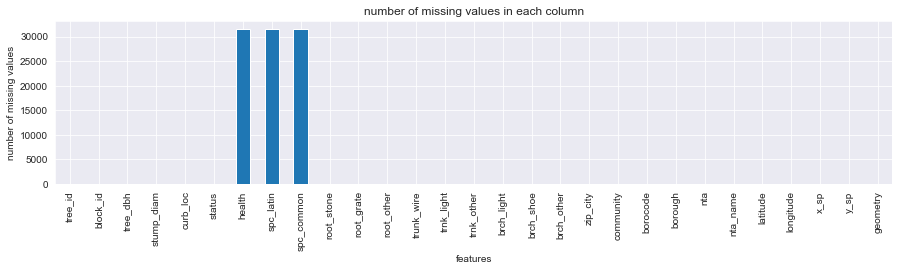

In [11]:
plt.figure(figsize=(15,3))
tree_data.isna().sum().plot.bar()
plt.ylabel('number of missing values')
plt.xlabel('features')
plt.title('number of missing values in each column');

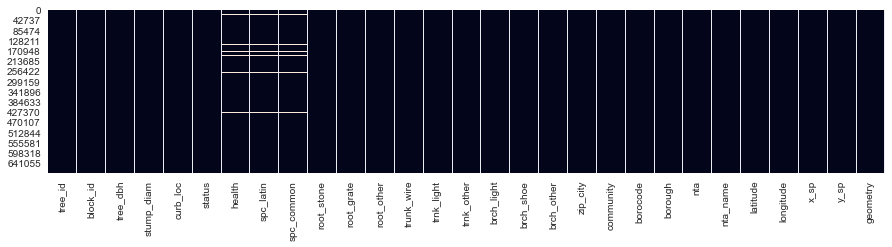

In [12]:
plt.figure(figsize=(15,3))
ax = sns.heatmap(tree_data.isnull(), cbar=False);

In [13]:
tree_data.loc[tree_data['status'] == 'Alive'].isnull().sum()

tree_id       0
block_id      0
tree_dbh      0
stump_diam    0
curb_loc      0
status        0
health        1
spc_latin     5
spc_common    5
root_stone    0
root_grate    0
root_other    0
trunk_wire    0
trnk_light    0
trnk_other    0
brch_light    0
brch_shoe     0
brch_other    0
zip_city      0
community     0
borocode      0
borough       0
nta           0
nta_name      0
latitude      0
longitude     0
x_sp          0
y_sp          0
geometry      0
dtype: int64

In [14]:
tree_data.fillna('Unknown', inplace=True)

Fill missing values with 'Unknown'.

In [15]:
tree_data.loc[tree_data['status'] != 'Alive']['health'].value_counts()

Unknown    31615
Name: health, dtype: int64

In [16]:
tree_data.loc[tree_data['status'] != 'Alive']['spc_latin'].value_counts()

Unknown                               31614
Gleditsia triacanthos var. inermis        1
Name: spc_latin, dtype: int64

In [17]:
tree_data.loc[tree_data['status'] != 'Alive']['spc_common'].value_counts()

Unknown        31614
honeylocust        1
Name: spc_common, dtype: int64

# Finding 1: 
i) There are 95% values in the data set with no missing value.
ii) A missing value pattern is found here. Frequently, 'health', 'spc_latin', and 'spc_common' are missing together. iii) The status of trees with missing values is either stump or dead.
iv) Accordingly, we may only use trees with an alive status in our tree species detection.

# Find most common tree species

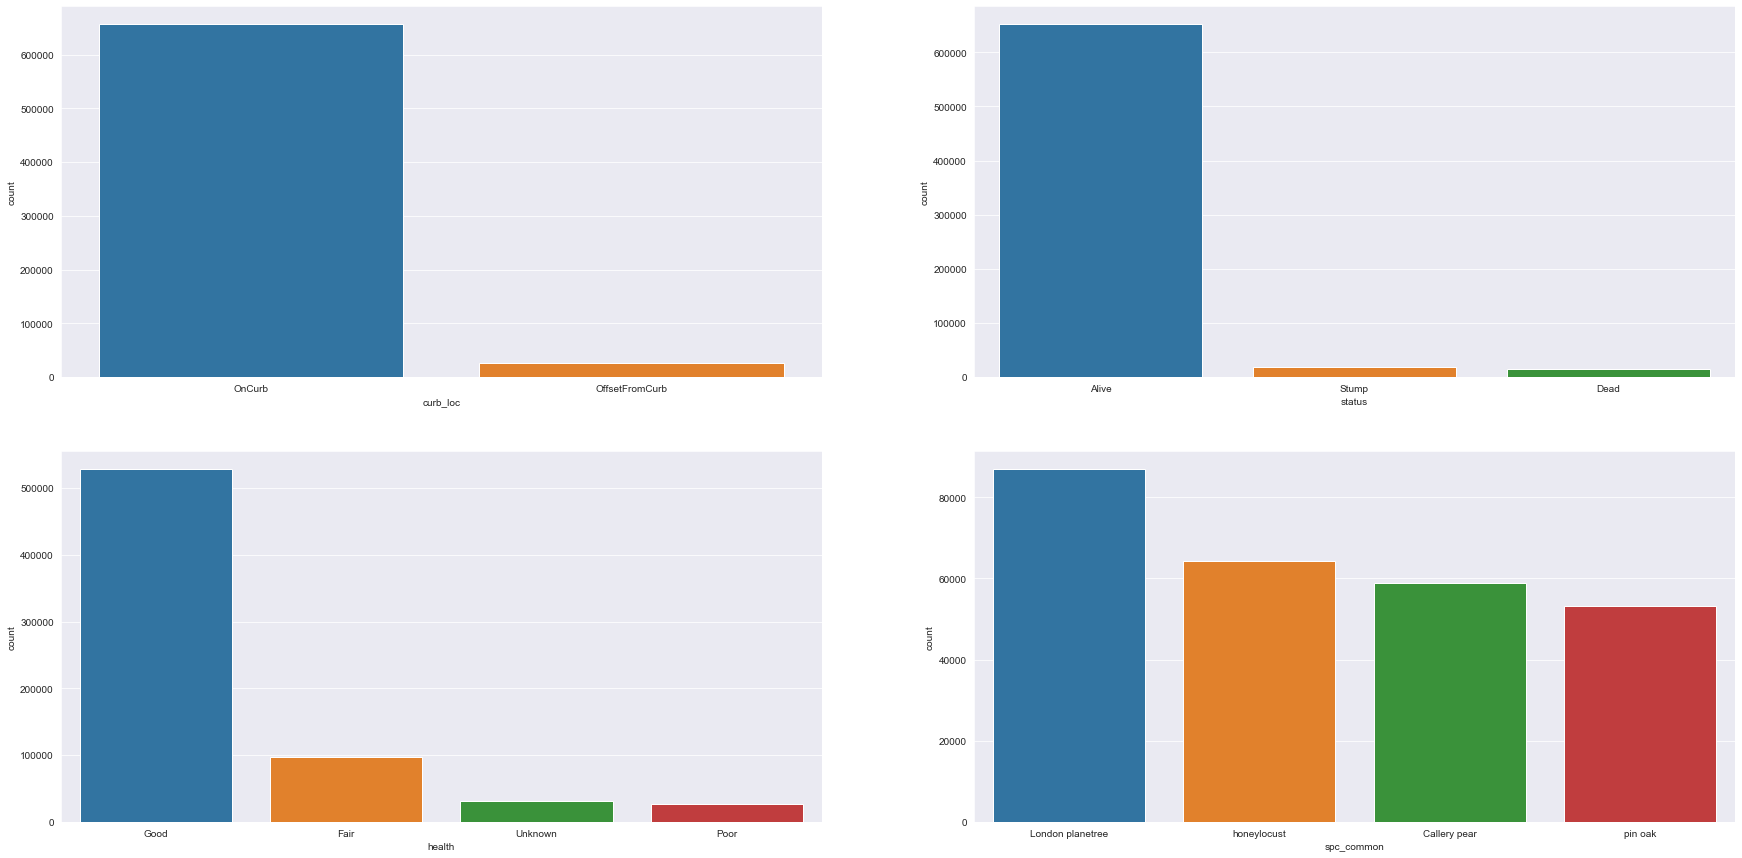

In [18]:
others = ['curb_loc', 'status', 'health', 'spc_common']

fig, axes = plt.subplots(2, 2, figsize=(30,15))
count = 0
for i in range(0, 2):
    for j in range(0, 2):
        sns.countplot(ax=axes[i][j], x=others[count], data=tree_data, \
                      order=tree_data[others[count]].value_counts().iloc[:4].index)
        count += 1

In [19]:
tree_data['spc_common'].value_counts()[:4]

London planetree    87014
honeylocust         64264
Callery pear        58931
pin oak             53185
Name: spc_common, dtype: int64

# Finding 2: 
We find top 4 most common tree species. 1) London plane tree, 2) honeylocust, 3) Callery pear, 4) pin oak.

# Plot top 4 most common tree species

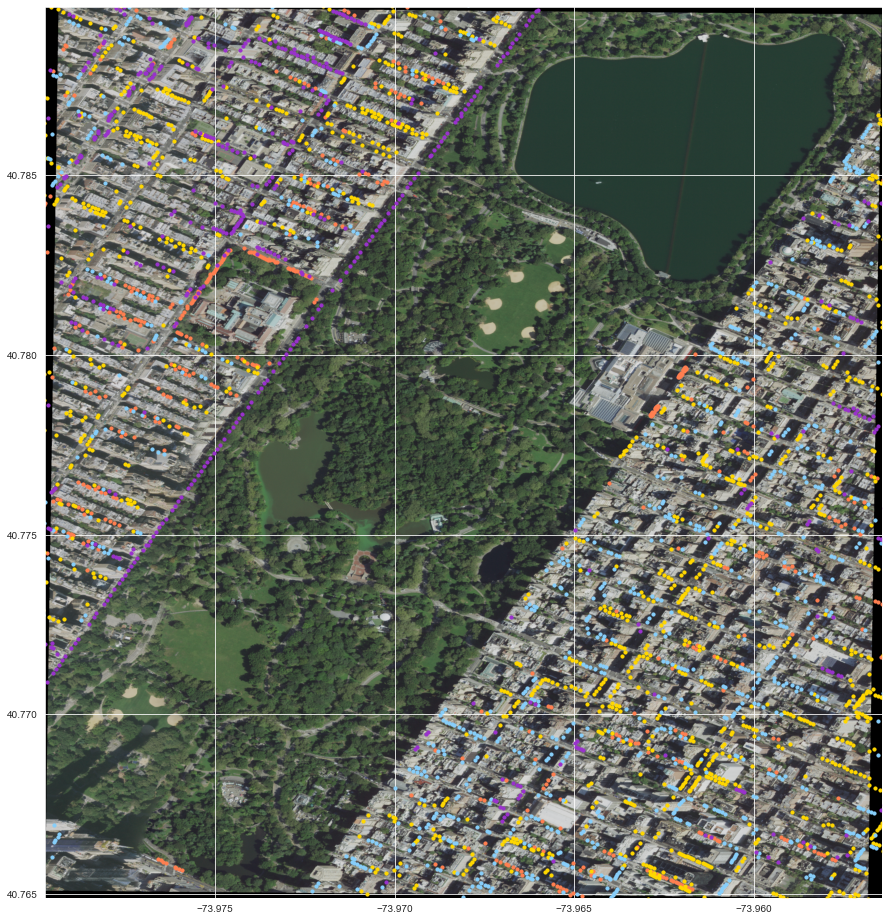

In [20]:
London_planetree = tree_data.loc[tree_data['spc_common'] == 'London planetree']
honeylocust = tree_data.loc[tree_data['spc_common'] == 'honeylocust']
Callery_pear = tree_data.loc[tree_data['spc_common'] == 'Callery pear']
pin_oak = tree_data.loc[tree_data['spc_common'] == 'pin oak']

# show point and raster on a matplotlib plot
fig, ax = plt.subplots(figsize=(15,20))
London_planetree.plot(ax=ax, color='coral', markersize=10)
honeylocust.plot(ax=ax, color='gold', markersize=10)
Callery_pear.plot(ax=ax, color='lightskyblue', markersize=10)
pin_oak.plot(ax=ax, color='darkorchid', markersize=10)
show(park_raster, ax=ax);

# Plot alive and non-alive trees

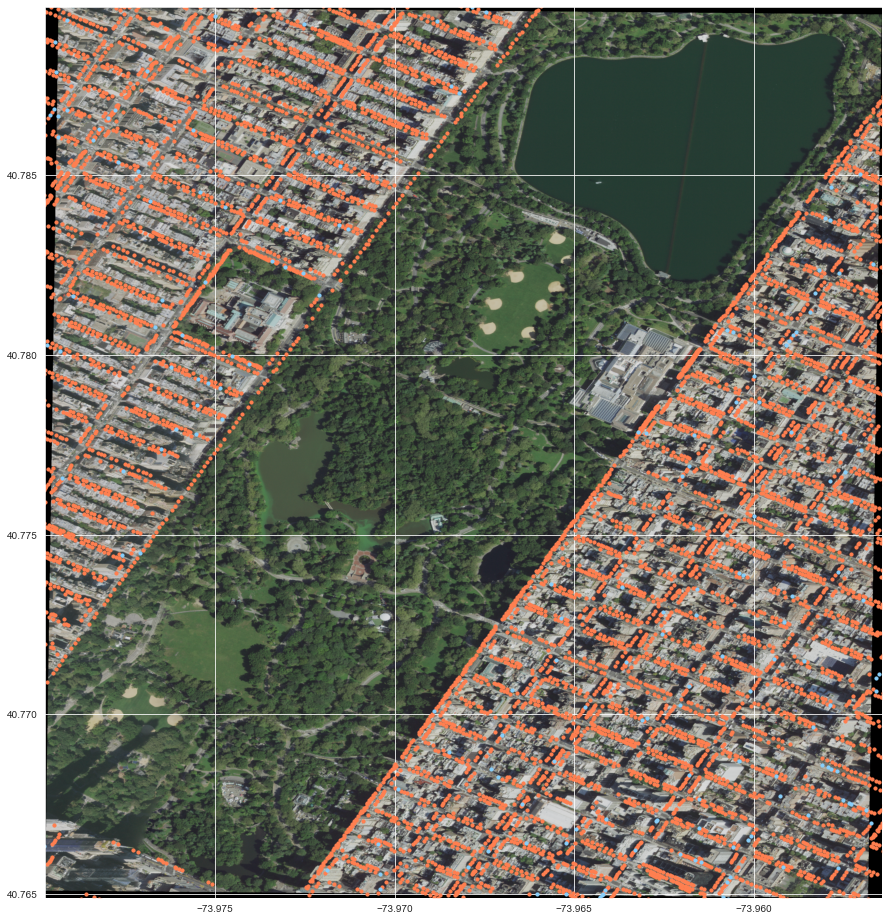

In [21]:
alive = tree_data.loc[tree_data['status'] == 'Alive']
non_alive = tree_data.loc[tree_data['status'] != 'Alive']

# show point and raster on a matplotlib plot
fig, ax = plt.subplots(figsize=(15,20))
alive.plot(ax=ax, color='coral', markersize=10)
non_alive.plot(ax=ax, color='lightskyblue', markersize=10)
show(park_raster, ax=ax);

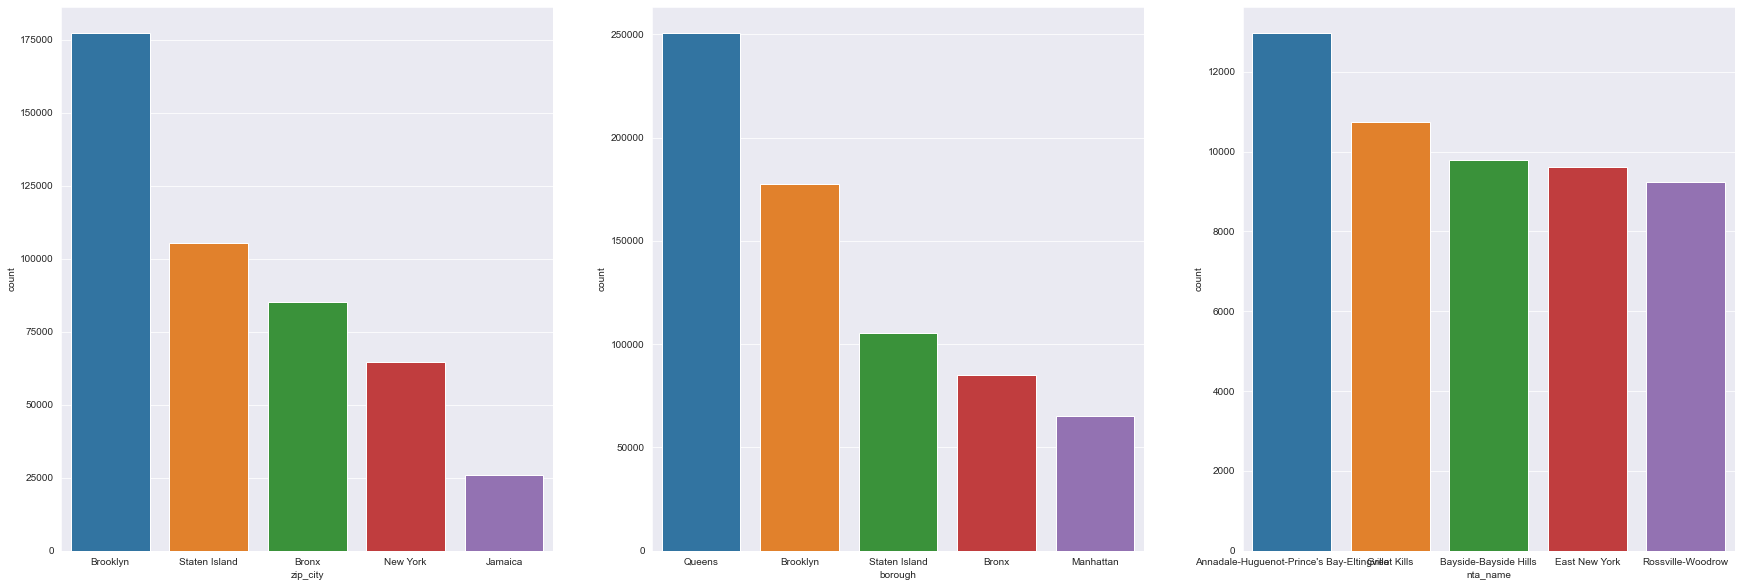

In [22]:
places = ['zip_city', 'borough', 'nta_name']
fig, axes = plt.subplots(1, 3, figsize=(30,10))
count = 0
for i in range(0, 3):
    sns.countplot(ax=axes[i], x=places[count], data=tree_data, \
                      order=tree_data[places[count]].value_counts().iloc[:5].index)
    count += 1

In [23]:
top4 = ['London planetree', 'honeylocust', 'Callery pear', 'pin oak']
df = tree_data.copy()
df.loc[~df['spc_common'].isin(top4), 'spc_common'] =  'others'

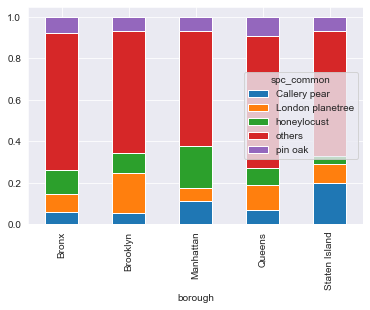

In [24]:
df.groupby('borough')['spc_common'].value_counts(normalize=True).unstack('spc_common').plot.bar(stacked=True);

# Extract four single-band rasters from a multi-band raster

In [25]:
for band in range(1, park_raster.count+1):
    single_band = park_raster.read(band)

    # create the output filename
    out_name = os.path.basename('NYC_CentralPark_84.tif')
    file, ext = os.path.splitext(out_name)
    name = file + "_" + "B" + str(band) + ".tif"

    # copy the metadata
    out_meta = park_raster.meta.copy()
    out_meta.update({"count": 1})

    # save the single-band raster
    with rasterio.open(name, "w", **out_meta) as dest:
        dest.write(single_band, 1)

# Measure NDVI

Question: do we need to normalize value in each band raster file so that the [min, max] = [0,1]?

In [26]:
b1 = rasterio.open('NYC_CentralPark_84_B1.tif')
b4 = rasterio.open('NYC_CentralPark_84_B4.tif')
red = b1.read().astype(float)
nir = b4.read().astype(float)
np.seterr(divide='ignore', invalid='ignore')
# calculate NDVI (NDVI = (NIR — VIS)/(NIR + VIS))
ndvi = np.where(nir + red == 0, 0, (nir - red)/(nir + red))

# write the NDVI image
meta = b4.meta
meta.update(driver='GTiff')
meta.update(dtype=rasterio.float32)

with rasterio.open('NDVI.tif', 'w', **meta) as dst:
    dst.write(ndvi.astype(rasterio.float32))

# Plot all labeled points on NDVI.tif

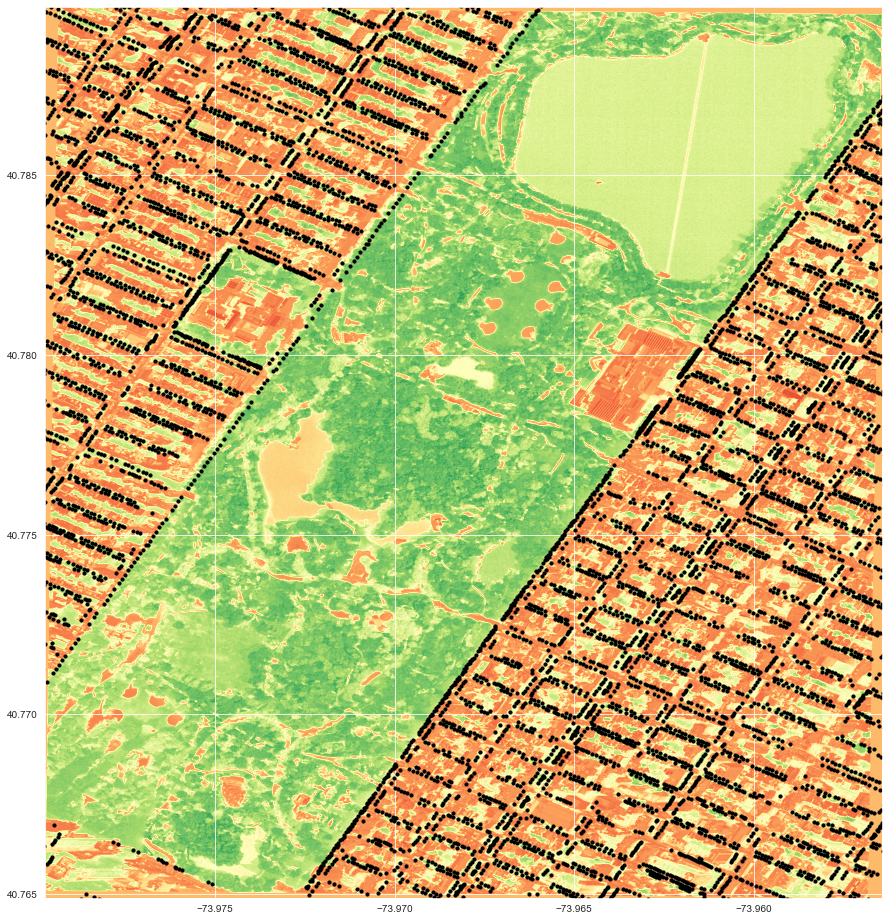

In [27]:
# open NDVI raster file
NDVI_raster = rasterio.open('NDVI.tif')
# show point and raster on a matplotlib plot
fig, ax = plt.subplots(figsize=(15,20))
tree_data.plot(ax=ax, color='black', markersize=10)
show(NDVI_raster, cmap='RdYlGn', ax=ax);

# Statistics

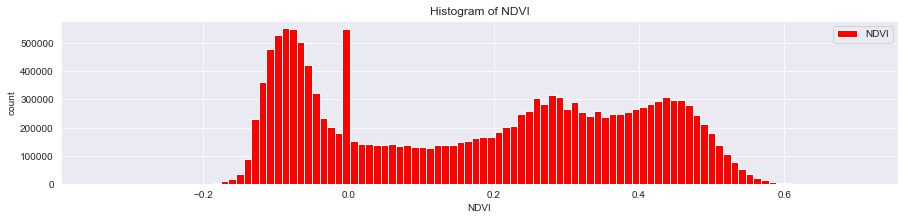

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(15,3))
show_hist(NDVI_raster, bins=100, label='NDVI', ax=ax)
ax.set_xlabel('NDVI')
ax.set_ylabel('count')
ax.set_title('Histogram of NDVI');

Calculations of NDVI for a given pixel always result in a number that ranges from minus one (-1) to plus one (+1); however, no green leaves gives a value close to zero. A zero means no vegetation and close to +1 (0.8 - 0.9) indicates the highest possible density of green leaves.

We see a multimodal distribution which had more than one mode, suggesting that we detect different landscapes/tree coverages within this area. 

In [29]:
ndvi_file = NDVI_raster.read()
print('Minimum and Maximum of NDVI: ', [np.min(ndvi_file), np.max(ndvi_file)])
print('Mean of NDVI: ', np.mean(ndvi_file))

Minimum and Maximum of NDVI:  [-0.34339622, 0.70422536]
Mean of NDVI:  0.17706381


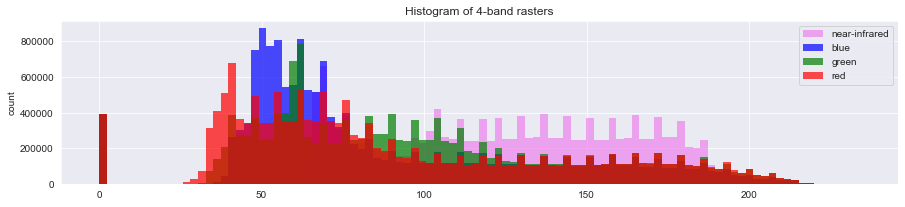

In [30]:
labels = ['red', 'green', 'blue', 'near-infrared']
fig, ax = plt.subplots(1, 1, figsize=(15,3))
show_hist(park_raster, bins=100, histtype='stepfilled', lw=0.0, label=labels, stacked=False, alpha=0.7, ax=ax)
ax.set_xlabel('')
ax.set_ylabel('count')
ax.set_title('Histogram of 4-band rasters');